# Anonymization of Company Names from Earnings Call Trascripts

This is a demo of **Named Entity Swapping** proposed in the paper:

Greve, J., & Sablica, L. (2025). Named Entity Swapping for Metadata Anonymization in a Text Corpus. *arXiv preprint arXiv:2505.21128.*

# Preprocessing



Let's start with the preprocessing. Functions to import are in the file **earningsCallPreprocessing.py**.

In [215]:
# import relevant packages
import numpy as np
import pandas as pd

import os # for file reading
import glob # for the same purpose
import re # lots of regex stuff for preprocessing
import datetime # for extracting calls from specific quarter
# for reading Pdf and error handling
from pypdf import PdfReader,PdfWriter
from pypdf.errors import PdfStreamError

# func programming stuff
from toolz import curry, pipe


The total number of earnings calls for each sector aggregated across quarters and companies in our dataset is given as follows:

In [217]:
ticker_df = pd.read_csv('ticker_naics_SP500_per_year.csv').merge(pd.read_csv('Comprehensive_Tickers_with_NAIC_Industry_Labels.csv'),
                                                                left_on = 'ticker', right_on = 'Ticker')
ticker_df['Industry'].value_counts()

Industry
Manufacturing                                                               3375
Finance and Insurance                                                       1250
Utilities                                                                    624
Information                                                                  592
Retail Trade                                                                 413
Mining, Quarrying, and Oil and Gas Extraction                                369
Real Estate and Rental and Leasing                                           368
Transportation and Warehousing                                               346
Professional, Scientific, and Technical Services                             211
Accommodation and Food Services                                              196
Wholesale Trade                                                              187
Administrative and Support and Waste Management and Remediation Services     166
Health Care and Soc

We try anonymizing earnings call transcripts in the *Retail Trade* sector. The quarter we pick is Q1, 2016 (for no particular reason).

In [253]:
files = os.path.join(os.getcwd(),'SP500')
year = 2016
qrt = 1
industryname = 'Retail Trade'

In [254]:
@curry
def map_func(func, iterable):
    return map(func, iterable)

@curry
def filter_func(func, iterable):
    return filter(func, iterable)

@curry
def dateMatched(qrt, year, filepath):
    try:
        date = re.search(r'Call,\s(.*)\.pdf',filepath).group(1)
        date_dtobj = datetime.datetime.strptime(date,'%b %d, %Y')
        q_date = pd.Timestamp(date_dtobj).quarter
        y_date = pd.Timestamp(date_dtobj).year
        if q_date == qrt and y_date == year:
            return filepath
        else:
            None
    except TypeError:
        None


@curry
def industryMathced(industryname, ticker_df, filepath):
    try:
        reader = PdfReader(filepath)
        firstpage = reader.pages[0].extract_text()
        try:
            ticker = re.search(r'(NYSE|NasdaqGS|XTRA|BATS|ASX|NasdaqGM|TSX):([A-Z\.]+)', firstpage).group(2)
            try: 
                if ticker_df[ticker_df.ticker == ticker].iloc[0].Industry == industryname:           
                    return filepath
            except IndexError:
                None
        except AttributeError:
            None
    except (PdfStreamError, AttributeError) as e:
        None

In [255]:
%%capture
hoge = lambda x: industryMathced(industryname, ticker_df)(dateMatched(qrt, year)(x))

matched_filepaths = pipe(glob.glob(os.path.join(files,'**/*.pdf'), recursive = True),
                map_func(hoge),
                filter_func(lambda x: x is not None),
                list)

In [257]:
matched_filepaths

['/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 76/Best Buy Co., Inc., Q4 2016 Earnings Call, Feb 25, 2016.pdf',
 '/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 76/Lowes Companies Inc., Q4 2016 Earnings Call, Feb 24, 2016.pdf',
 '/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 76/The TJX Companies, Inc., Q4 2016 Earnings Call, Feb 24, 2016.pdf',
 '/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 47/ULTA Salon, Cosmetics  Fragrance, Inc., Q4 2016 Earnings Call, Mar 10, 2016.pdf',
 '/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 47/Dollar Tree, Inc., Q4 2016 Earnings Call, Mar 01, 2016.pdf',
 '/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 47/Dollar General Corporation, Q4 2016 Earnings Call, Mar 10, 2016.pdf',
 '/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 47/Ross Stores Inc., Q4 2016 Earnings Call, Mar 01, 2016.pdf',
 '/home/wucloud/Documen

Now we carry out the preprocessing via the function **WriteNewPdf** in a separate python file called **earningsCallPreprocessing.py**

This operation may take time for some cases (not this example tho), so we do thread pooling.

In [6]:
from earningsCallPreprocessing import WriteNewPdf
from multiprocessing.dummy import Pool
from functools import partial

In [258]:
foldername = 'tmp_earningscall'

In [259]:
%%capture
with Pool() as pool:
    pool.map(partial(WriteNewPdf, folder = foldername), matched_filepaths)

The file name of each pdf file is converted "Company IDX.pdf" and we keep the original name in a separate dictionary filedic. This is because later, we will pass pdf files (turned into chunks of texts) and their metadata vector (including file names) to [vector stores](https://docs.llamaindex.ai/en/stable/module_guides/storing/vector_stores/).

In [260]:
filedic = {}
for idx,fname in enumerate(os.listdir(foldername)):
    filedic.update({str(fname):filedic.get(str(fname),'Company'+str(idx))})
for fname in os.listdir(foldername):
    os.rename(foldername+'/'+fname,foldername+'/'+filedic[fname]+'.pdf')


In [261]:
filedic

{'AAP.pdf': 'Company0',
 'TGT.pdf': 'Company1',
 'TJX.pdf': 'Company2',
 'WMT.pdf': 'Company3',
 'TSCO.pdf': 'Company4',
 'DLTR.pdf': 'Company5',
 'COST.pdf': 'Company6',
 'ULTA.pdf': 'Company7',
 'LOW.pdf': 'Company8',
 'WBA.pdf': 'Company9',
 'EBAY.pdf': 'Company10',
 'HD.pdf': 'Company11',
 'DG.pdf': 'Company12',
 'BBY.pdf': 'Company13',
 'AMZN.pdf': 'Company14',
 'ROST.pdf': 'Company15',
 'ORLY.pdf': 'Company16',
 'KR.pdf': 'Company17',
 'AZO.pdf': 'Company18'}

The next step is to carry out chunking. Here we use the semantic chunker (which requires a text embedding) from LLamaIndex for this task.

In [11]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.node_parser import SemanticSplitterNodeParser

First, we must specify some settings to carry out the semantic chunking. Important settings that may have an effect on the overall anonymization outcomes are:
* breakpoint threshold (0-100): the greater, the more dissimilar the two consequtive texts need to be to be split, resulting in bigger chunks.
* text embeddings: for this demo, we use [Insutructor embeddings](https://instructor-embedding.github.io/) which generates domain-specific embeddings based on the instruction (details covered later).
* metadata function: we need to ensure that vectorstore does not have unwanted metadata from the pdf file. Metadata function is given in **earningsCallPreprocessing.py** file as function **getMeta**

First, we specify the breakpoint threshold and also obtain the metadata function from the aforementioned .py file. In addition, we define the variable instruction which is the instructor given to the Instuctor embedding.

In [287]:
from earningsCallPreprocessing import getMeta
break_thrsh = 75 # breakpoint threshold
instruction = "Represent earnings call trascripts for sentiment analysis"

Next, we construct a wrapper class so that instructor embedding can be inserted into the **SemanticSplitterNodeParser** function from the LlamaIndex.

In [285]:
from typing import List
from llama_index.core.base.embeddings.base import BaseEmbedding
from pydantic import PrivateAttr
from sentence_transformers import SentenceTransformer

class InstructorEmbedding(BaseEmbedding):
    _model: SentenceTransformer = PrivateAttr()
    _instruction: str = PrivateAttr()
    def __init__(self, model_name: str = "hkunlp/instructor-large", instruction: str = instruction):
        super().__init__()
        self._model = SentenceTransformer(model_name)
        self._instruction = instruction  
    def _get_instruction_input(self, text: str) -> List[str]:
        return [self._instruction, text]
    def embed(self, text: str) -> List[float]:
        return self._model.encode([self._get_instruction_input(text)])[0].tolist()
    def embed_query(self, text: str) -> List[float]:
        return self._model.encode([["Represent the query for retrieval:", text]])[0].tolist()
    def _aget_query_embedding(self, texts: List[str]) -> List[List[float]]:
        return self._model.encode([["Represent the query for retrieval:", t] for t in texts])
    def _get_query_embedding(self, texts: List[str]) -> List[List[float]]:
        return self._model.encode([["Represent the query for retrieval:", t] for t in texts])
    def _get_text_embedding(self, text: List[str]) -> List[float]:
    # only this function and __init__ matters, others are for not getting errors
             return self._model.encode([self._get_instruction_input(text)])[0].tolist()

Once the wrapper class is given, it can be passed to **SemanticSplitterNodeParser** for chunking.

In [286]:
embed_model = InstructorEmbedding()
documents = SimpleDirectoryReader(foldername,raise_on_error=True
                                  ,file_metadata= getMeta).load_data(num_workers=12)
splitter = SemanticSplitterNodeParser(
buffer_size=1, breakpoint_percentile_threshold=break_thrsh, embed_model=embed_model
)
#SentenceSplitter(chunk_size=126, chunk_overlap=20)
index = VectorStoreIndex.from_documents(documents,
                                        transformations=[splitter],
                                        embed_model=embed_model,
                                        show_progress = False)  

Now, the vector store contains chunked earnings call transcripts with almost no metadata (only the filename, which are in the format "Company #.pdf" are given as metadata) and the corresopnding embedding vector generated from the Instructor embedding. 

Next step is to cluster these chunks based on loading on their embedding vectors.

# Clustering of Text Chunks on Embedding Space

We carry out clustering of text chunks based on their embedding vectors. As embedding vectors are norm one, they can be considered a point on a sphere. Hence, we carry out clustering on spheres using **spheroids** package.

In [288]:
from spheroids import SphericalClustering
import torch # matrices supplied to SphericalClustering model should be pytorch tensors

In [269]:
embdgs_tmp = [[instruction,index.docstore.docs.get(key).get_content()] for key in index.docstore.docs.keys()]
model_inst = SentenceTransformer('hkunlp/instructor-large')
embdgs_inst = model_inst.encode(embdgs_tmp)

From the embedding vectors in vector store, we construct the pytorch tensor which will be passed to the **SphericalClusering** for clustering.

In [271]:
Y = torch.from_numpy(np.array(embdgs_inst))
model = SphericalClustering(
    num_covariates=1,
    response_dim=Y.shape[1],
    num_clusters=30,
    distribution='PKBD', 
    min_weight=1e-5
)    

ll = model.fit_no_covariates(Y, num_epochs=300, tol = 1e-2)

In [ ]:
embdgs = [[key, index.docstore.docs.get(key).metadata['file_name']] + \
          index.vector_store.get(key) for key in index.docstore.docs.keys()]
Y = np.array(pd.DataFrame(embdgs).iloc[:,2:])
Y = torch.from_numpy(Y)
model = SphericalClustering(
    num_covariates=1,
    response_dim=Y.shape[1],
    num_clusters=30,
    distribution='scauchy', 
    min_weight=1e-3
)    

ll = model.fit_no_covariates(Y, num_epochs=500, tol = 1e-15)


In [312]:
?model.fit_no_covariates

Signature: model.fit_no_covariates(Y, num_epochs=100, tol=1e-08)
Docstring:
Fits the model when there are no covariates using the EM algorithm implemented in C++.

Args:
    Y (torch.Tensor or numpy.ndarray): Response variable.
    num_epochs (int): Maximum number of EM iterations.
    tol (float): Convergence tolerance.

Returns:
    Tuple[numpy.ndarray, numpy.ndarray]: Estimated mean directions (mu) and concentrations (rho).
File:      ~/.local/lib/python3.11/site-packages/spheroids/model.py
Type:      method

In [311]:
?SphericalClustering

Init signature:
SphericalClustering(
    num_covariates,
    response_dim,
    num_clusters,
    distribution='pkbd',
    min_weight=0.05,
    device='cpu',
)
Docstring:     
A PyTorch module for spherical clustering using Spherical Cauchy or PKBD distributions.

Parameters:
    num_covariates (int): Number of covariates.
    response_dim (int): Dimensionality of the response variable.
    num_clusters (int): Number of clusters.
    distribution (str): Distribution type ('spcauchy' or 'pkbd').
    min_weight (float): Minimum weight threshold for cluster survival.
    device (str): Device to allocate tensors ('cpu' or 'cuda').

Properties:
    active_components:
        Returns the number of active clusters.
    df:
        Returns the degrees of freedom of the model.

Methods:
    forward(X):
        Performs a forward pass to compute cluster embeddings.
        Args:
            X (torch.Tensor): Covariates.
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Normalized em

In [314]:
pd.Series(np.argmax(model.W,axis = 1)).value_counts()

16    98
0     97
26    76
15    73
13    68
22    68
24    68
14    57
11    45
7     43
1     41
4     39
2     37
20    36
17    29
23    29
18    25
3     23
12    23
9     22
27    21
6     20
10    20
8     20
25    19
19    18
29    17
5     16
21    14
28     6
Name: count, dtype: int64

In [317]:
pd.Series(np.argmax(model.W,axis = 1)).value_counts()

27    98
22    72
1     70
23    67
28    63
26    59
13    51
19    50
8     48
24    45
15    44
7     44
14    44
0     41
2     41
6     38
25    38
10    37
4     36
16    30
21    30
11    27
18    24
29    19
12    14
5     12
9      9
17     7
20     7
3      3
Name: count, dtype: int64

In [290]:
pd.Series(np.argmax(model.W,axis = 1)).value_counts()

16    98
11    91
2     88
15    87
5     76
0     73
19    73
17    72
6     70
13    67
3     64
4     52
8     50
7     50
14    43
18    33
10    26
9     25
1     16
12    14
Name: count, dtype: int64

In [96]:
list(index.docstore.docs.keys())[0]

'c5daf325-234a-4bc9-b43b-f6be799d2cd2'

In [273]:
inv_map = {v: k for k, v in filedic.items()}
def numfirms_clst(clst_idx):
    g0 = [list(index.docstore.docs.keys())[idx] for idx, embd in enumerate(np.argmax(model.W, axis=1)) if embd == clst_idx]
    tmp = []
    for key in g0:
        tmp.append(inv_map[re.search(r'(Company.*).pdf', index.docstore.docs.get(key).get_metadata_str()).group(1)])
    return((clst_idx, len(np.unique(tmp))))
with Pool() as pool:
    clst_counts = pool.map(numfirms_clst, np.unique(np.argmax(model.W, axis = 1)))



In [305]:
inv_map = {v: k for k, v in filedic.items()}
def numfirms_clst(clst_idx):
    g0 = [embdgs[idx][0] for idx, embd in enumerate(np.argmax(model.W, axis=1)) if embd == clst_idx]
    tmp = []
    for key in g0:
        tmp.append(inv_map[re.search(r'(Company.*).pdf', index.docstore.docs.get(key).get_metadata_str()).group(1)])
    return((clst_idx, len(np.unique(tmp))))
with Pool() as pool:
    clst_counts = pool.map(numfirms_clst, np.unique(np.argmax(model.W, axis = 1)))


In [20]:
clst_counts

[(np.int64(0), 24),
 (np.int64(1), 12),
 (np.int64(2), 22),
 (np.int64(3), 19),
 (np.int64(4), 23),
 (np.int64(5), 22),
 (np.int64(6), 18),
 (np.int64(7), 25),
 (np.int64(8), 6),
 (np.int64(9), 16),
 (np.int64(10), 12),
 (np.int64(11), 14),
 (np.int64(12), 25),
 (np.int64(13), 25),
 (np.int64(14), 2),
 (np.int64(15), 24),
 (np.int64(16), 14),
 (np.int64(17), 18),
 (np.int64(18), 25),
 (np.int64(19), 18)]

In [306]:
df1 = pd.DataFrame(clst_counts)
df1.columns = ['idx','firm_counts']
df2 = pd.Series(np.argmax(model.W,axis = 1)).value_counts()
df2 = pd.DataFrame([df2.index,df2]).transpose()
df2.columns = ['idx','chunk_counts']
df3 = pd.DataFrame([range(0,50), np.argsort(ll[1])]).transpose()
df3.columns = ['Low_concentration','idx']
df_res = pd.merge(df3,pd.merge(df1,df2, on = 'idx'), on = 'idx').sort_values('Low_concentration',ascending=False)
df_res

,Low_concentration,idx,firm_counts,chunk_counts
39,39.0,5.0,19,112
38,38.0,35.0,8,11
37,37.0,21.0,18,88
36,36.0,4.0,2,2
35,35.0,26.0,9,11
34,34.0,22.0,9,13
33,33.0,27.0,5,5
32,32.0,20.0,19,36
31,31.0,1.0,11,17
30,30.0,36.0,3,3


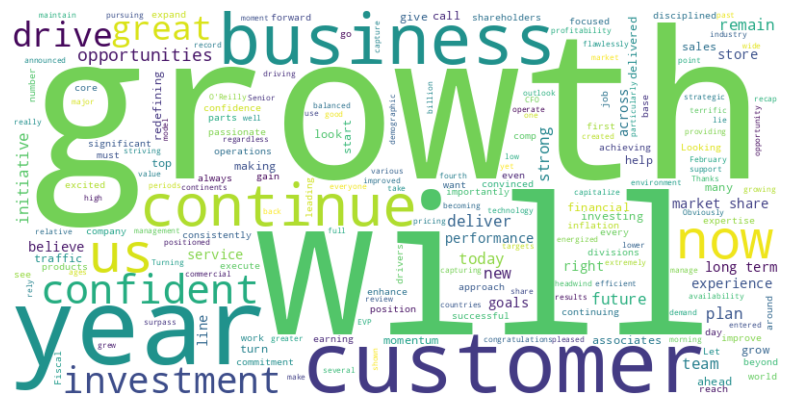

In [308]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
with open('clst17.txt','r', encoding = 'utf-8') as file:
    text = file.read()
    text = re.sub(r'[A-Z]+\.pdf','',text)
    text = re.sub(r'Executive\d','',text)
    text = re.sub(r'Company Name','',text)
    text = re.sub(r'quarter','',text)
wordcloud = WordCloud(width = 800, height = 400, background_color='white').generate(text)
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [179]:
re.sub(r'Executive \d','','Executive1 as it shoud, BTI.pdf')

'Executive1 as it shoud, BTI.pdf'

In [276]:
ll[1]

array([0.7536264 , 0.81017649, 0.76071538, 0.74511276, 0.80759916,
       0.74977894, 0.76880565, 0.75437605, 0.73515723, 0.79139093,
       0.75142419, 0.76298215, 0.76918351, 0.74425286, 0.72887024,
       0.74417525, 0.75913068, 0.74333178, 0.99999755, 0.7591042 ,
       0.70404846, 0.95320697, 0.76637918, 0.77441212, 0.73652229,
       0.79099046, 0.78276229, 0.76286571, 0.74835173, 0.99999755])

In [275]:
def writeclst(idxxx):
    clst_idx = idxxx
    g0 = [list(index.docstore.docs.keys())[idx] for idx, embd in enumerate(np.argmax(model.W, axis=1)) if embd == clst_idx]
    # [print(index.docstore.docs.get(key).get_content()+'\n\n\n############') for key in g0]
    speeches = open('clst' + str(clst_idx) + '.txt', 'w')
    for key in g0:
        speeches.write(textwrap.fill(index.docstore.docs.get(key).get_content(), 200) + \
                       "\n\n\n" + \
                       inv_map[re.search(r'(Company.*).pdf', index.docstore.docs.get(key).get_metadata_str()).group(1)] + \
                       '\n\n\n\n')
    speeches.close()
with Pool() as pool:
    pool.map(writeclst,np.unique(np.argmax(model.W,axis = 1)))

In [307]:
def writeclst(idxxx):
    clst_idx = idxxx
    g0 = [embdgs[idx][0] for idx, embd in enumerate(np.argmax(model.W, axis=1)) if embd == clst_idx]
    # [print(index.docstore.docs.get(key).get_content()+'\n\n\n############') for key in g0]
    speeches = open('clst' + str(clst_idx) + '.txt', 'w')
    for key in g0:
        speeches.write(textwrap.fill(index.docstore.docs.get(key).get_content(), 200) + \
                       "\n\n\n" + \
                       inv_map[re.search(r'(Company.*).pdf', index.docstore.docs.get(key).get_metadata_str()).group(1)] + \
                       '\n\n\n\n')
    speeches.close()
with Pool() as pool:
    pool.map(writeclst,np.unique(np.argmax(model.W,axis = 1)))